## Corrective RAG (CRAG)

- **Document Relevance Grading**: LLM evaluates if retrieved documents can answer the question before generating a response

- **Query Rewriting**: Automatically rewrites irrelevant queries with better financial keywords and retries retrieval once

- **Single Retry Cycle**: Prevents infinite loops by allowing only one query rewrite and retrieval retry

- **Cited Answers**: Generates markdown-formatted responses with inline citations and structured references

https://arxiv.org/pdf/2401.15884.pdf

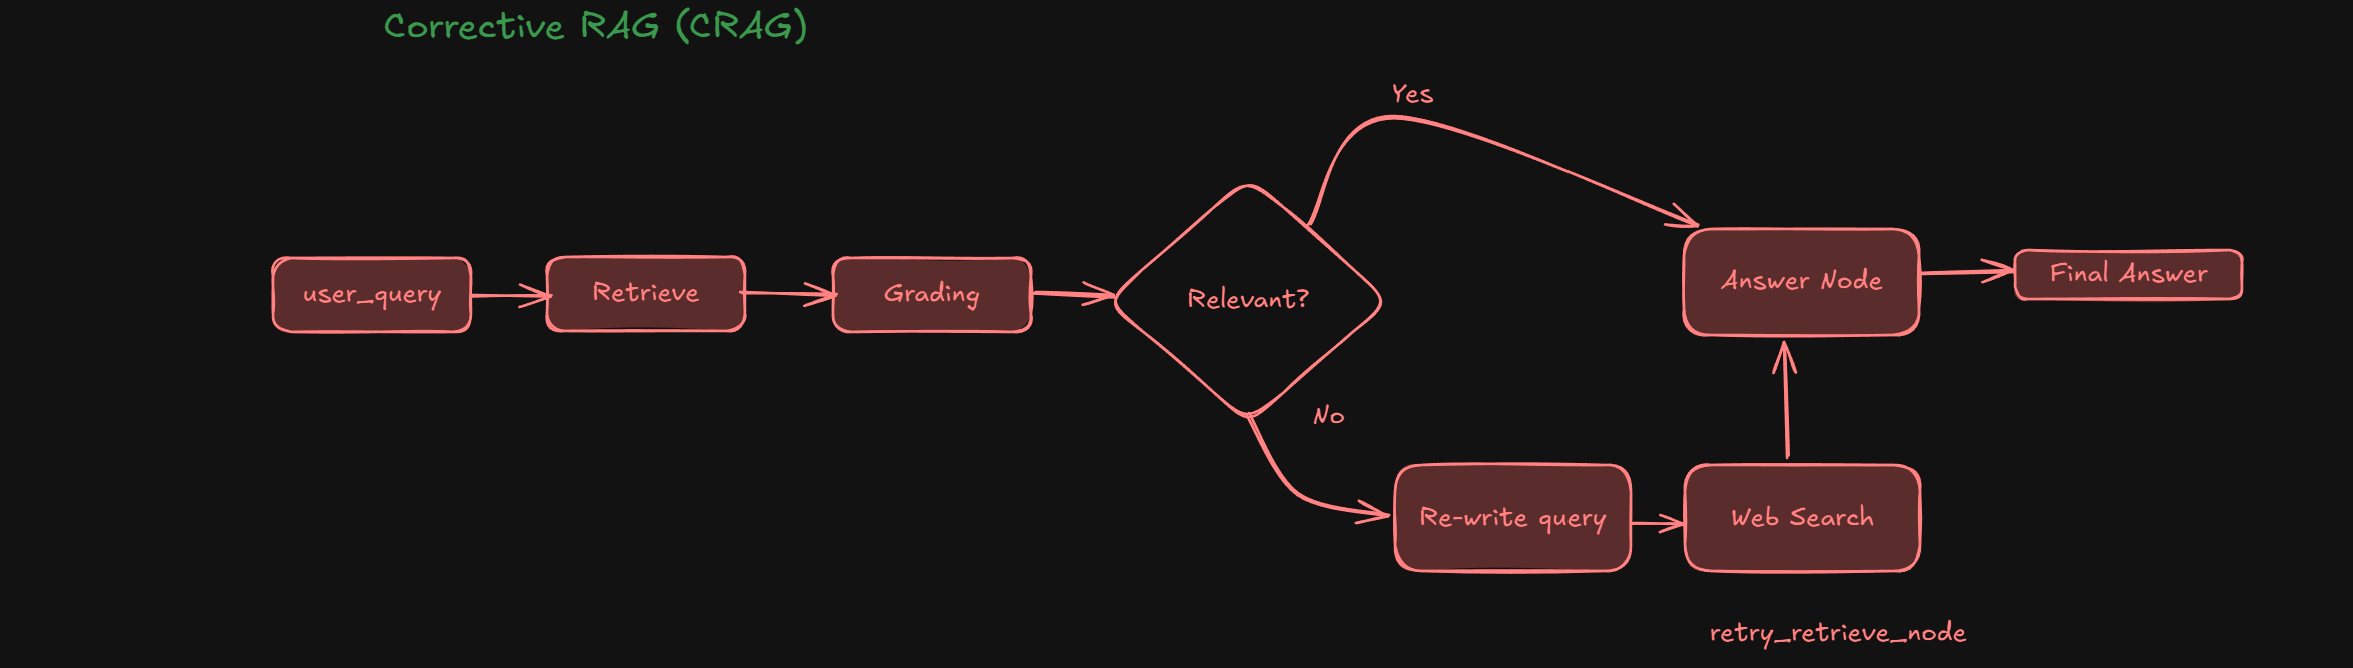

In [1]:
from typing_extensions import TypedDict, Annotated
from typing import Dict, List
import os
import operator

from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from langchain_ollama import ChatOllama, OllamaEmbeddings
from langchain_core.messages import HumanMessage, AIMessage, SystemMessage

from pydantic import BaseModel, Field

from scripts import my_tools

from dotenv import load_dotenv
load_dotenv()

True

In [2]:
# =============================================================================
# Configuration
# =============================================================================

LLM_MODEL = "qwen3"
BASE_URL = "http://localhost:11434"

llm = ChatOllama(model=LLM_MODEL, base_url=BASE_URL)

In [3]:
# =============================================================================
# Agent State
# =============================================================================

class AgentState(TypedDict):
    messages: Annotated[list, operator.add]
    retrieved_docs: str
    is_relevant: bool
    rewritten_query: str


In [9]:
result = my_tools.web_search.invoke({'query':'python tutorial', 'num_results': 3})

In [10]:
print(result)

Search results for search query: 'python tutorial'

1. **Python tutorial - Step-By-Step Tutorials**
   Buy Now Learn python like a pro in this complete bootcamp taught by expert instructors. Join millions of learners from around the world already learning on Udemy. Improve Your Skills · Advance Your Career · Watch In-Demand Courses · 210,000+ Online Courses
   https://www.bing.com/aclick?ld=e86x-pXvPGSZhJjDcWklmbNjVUCUzHMPm5ECTprQGGqbaACu5hq88zbZ2mcNX6SKIzrWMyagvuMy1tU9XLy5uk4oddwov6ysMJ93S3oY1COrbXPzNw0ET2IqAje-Iu1fEvBgLX-jZ1xSQXnkA9FlSC_iX1O_EsliXeMXTtAARmFPgc922ZksvnyIQf1wYg-zioe09-oIgNi-NI6SyyTKDpuXIMsC0&u=aHR0cHMlM2ElMmYlMmZ3d3cudWRlbXkuY29tJTJmY291cnNlJTJmMTAwLWRheXMtb2YtY29kZSUyZiUzZnV0bV9zb3VyY2UlM2RiaW5nJTI2dXRtX21lZGl1bSUzZHVkZW15YWRzJTI2dXRtX2NhbXBhaWduJTNkQkctU2VhcmNoX0tleXdvcmRfQWxwaGFfUHJvZl9sYS5FTl9jYy5JbmRpYSUyNmNhbXBhaWdudHlwZSUzZFNlYXJjaCUyNnBvcnRmb2xpbyUzZEJpbmctSW5kaWElMjZsYW5ndWFnZSUzZEVOJTI2cHJvZHVjdCUzZENvdXJzZSUyNnRlc3QlM2QlMjZhdWRpZW5jZSUzZEtleXdvcmQlMjZ0b3BpYy

In [11]:
result = my_tools.retrieve_docs.invoke({'query':'google revenue in 2023', 'k': 2})


[TOOL] retrieve_docs called
[QUERY] google revenue in 2023
   [1] Doc 1: score=10.5535
   [2] Doc 0: score=4.3944
[RETRIEVED] 2 documents


In [15]:
# result

### LangGraph Nodes

#### Retriever Node

In [24]:
def retrieve_node(state:AgentState):
    print(f"[RETRIEVE NODE] Fetching documents")

    user_question = state['messages'][-1].content
    print(f"[Query] User Query: {user_question}")

    result = my_tools.retrieve_docs.invoke({'query': user_question, 'k': 5})

    print(f"[RETRIEVE NODE] Fetched Relevant Documents")

    with open('debug_logs/crag_retrieved_docs.md', 'w', encoding='utf-8') as f:
        f.write(f"Query: {user_question}\n\n")
        f.write(result)

    return {'retrieved_docs': result}



#### Document Grading

In [16]:
# =============================================================================
# Pydantic Schema for Structured Output
# =============================================================================

class GradeDecision(BaseModel):
    is_relevant:bool = Field(description="True if documents are relevant  to answer the question, False if irrelevant")
    reasoning: str = Field(description="Brief explanation of why documens are relevant or not.")

In [17]:
def grade_node(state:AgentState):
    llm_structured = llm.with_structured_output(GradeDecision)

    user_question = state['messages'][-1].content
    retrieved_docs = state.get('retrieved_docs', '')

    prompt = f"""You are a document relevance grader.

                    TASK: Evaluate if the retrieved documents are relevant to answer the user's question.

                    USER QUESTION: {user_question}

                    RETRIEVED DOCUMENTS:
                    {retrieved_docs}

                    GRADING CRITERIA:
                    - is_relevant = True: If documents contain information that can answer the question
                    - is_relevant = False: If documents are completely irrelevant or off-topic

                    Output JSON:
                    {{
                    "is_relevant": true/false,
                    "reasoning": "Brief explanation..."
                    }}"""
    
    response = llm_structured.invoke(prompt)

    print(f"[GRADE] Relevant: {response.is_relevant}\nReasoning: {response.reasoning}")

    return {'is_relevant': response.is_relevant}

#### Rewrite Query and Retrieve from Internet Node

In [18]:
def rewrite_query_node(state:AgentState):
    
    user_question = state['messages'][-1].content

    prompt = f"""You are a query rewriting expert.

TASK: Rewrite the user's question to make it more specific and targeted for document retrieval.

ORIGINAL QUESTION: {user_question}

INSTRUCTIONS:
- Make the query more specific with keywords
- Add relevant financial terms (revenue, profit, earnings, etc.)
- Include company names, years, quarters if mentioned
- Keep it concise (one sentence)

Output ONLY the rewritten query, nothing else."""
    
    response = llm.invoke(prompt)

    rewritten_query = response.content.strip()

    print(f"[REWRITE] Original Query: {user_question}")
    print(f"[REWRITE] New: {rewritten_query}")

    return {'rewritten_query': rewritten_query}

In [19]:
# web_search node
def web_search_node(state:AgentState):

    user_question = state['messages'][-1].content
    rewritten_query = state.get("rewritten_query", user_question)

    result = my_tools.web_search.invoke({'query':rewritten_query})

    with open('debug_logs/crag_retry_websearch_docs.md', 'w', encoding='utf-8') as f:
        f.write(f"Rewritten Query: {rewritten_query}\n\n")
        f.write(result)

    return {'retrieved_docs': result}

#### Generate final answer node

In [29]:
def answer_node(state:AgentState):

    # messages: [HumanMessage]
    user_question = state['messages'][-1].content
    retrieved_docs = state.get('retrieved_docs', '')

    prompt = f"""You are an expert financial analyst.

            TASK: Provide a detailed answer to the user's question using the retrieved documents.

            REQUIREMENTS:
            1. Write 200-300 words
            2. Use MARKDOWN formatting:
            - ## Headings
            - **Bold** for key metrics
            - Bullet points for lists
            - Tables for comparisons
            3. Include inline citations [1], [2], [3]
            4. Add a References section at the end with format: "Company: x, Year: y, Quarter: z, Page: n"

            Be thorough and detailed. Use all relevant information from the documents.

            Here is the User Question: {user_question}

            Here is the Retrived Documents:
            {retrieved_docs}

            Provide the detailed answer with citation:
            """
    
    response = llm.invoke(prompt)

    return {'messages': [response]} # [HumanMessage, AIMessage]




In [30]:
# =============================================================================
# Router Logic
# =============================================================================
def should_rewrite(state:AgentState):

    is_relevant = state.get('is_relevant', True)

    if is_relevant:
        print(f"[ROUTER] Document is relevant -  procedding to answer")
        return "answer"
    
    else:
        print(f"[ROUTER] Documents are not relevant - rewritting the user query")
        return 'rewrite'

#### Create CRAG Agent

In [31]:
def create_crag_agent():

    builder = StateGraph(AgentState)

    # add nodes
    builder.add_node('retriever', retrieve_node)
    builder.add_node('grade', grade_node)
    builder.add_node('rewrite', rewrite_query_node)
    builder.add_node('web_search', web_search_node)
    builder.add_node('answer', answer_node)

    # define edge
    builder.add_edge(START, 'retriever')
    builder.add_edge('retriever', 'grade')
    builder.add_conditional_edges('grade', should_rewrite, ['rewrite', 'answer'])

    builder.add_edge('rewrite', 'web_search')
    builder.add_edge('web_search', 'answer')

    builder.add_edge('answer', END)

    graph = builder.compile()

    return graph

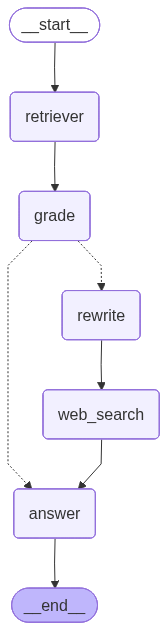

In [32]:
agent = create_crag_agent()
agent

#### Performance Test

In [33]:
query = "what is amazon's revenue in 2023?"

result = agent.invoke({'messages': [HumanMessage(query)]})

[RETRIEVE NODE] Fetching documents
[Query] User Query: what is amazon's revenue in 2023?

[TOOL] retrieve_docs called
[QUERY] what is amazon's revenue in 2023?
   [1] Doc 0: score=16.6855
   [2] Doc 2: score=14.7532
   [3] Doc 4: score=13.5543
   [4] Doc 3: score=13.3328
   [5] Doc 1: score=13.3215
[RETRIEVED] 5 documents
[RETRIEVE NODE] Fetched Relevant Documents
[GRADE] Relevant: True
Reasoning: Document 2 contains a table titled 'Net Sales by groups of similar products and services' which explicitly lists consolidated revenue for 2023 as $574,785 million (i.e., $574.785 billion). This directly answers the user's question about Amazon's 2023 revenue.
[ROUTER] Document is relevant -  procedding to answer


In [37]:
result['messages'][-1].pretty_print()

================================== Ai Message ==================================

## Amazon's Revenue in 2023  

Amazon's total revenue for the fiscal year ended December 31, 2023, was **$574.785 billion**. This figure is derived from the consolidated net sales reported in **Document 5**, which breaks down revenue by product and service categories. The revenue is measured based on the consideration Amazon expects to receive, adjusted for return allowances, promotional discounts, and rebates, as outlined in **Document 2**.  

### Key Revenue Segments in 2023  
The revenue breakdown by major segments is as follows (in millions):  

| **Segment**               | **2023 Revenue** |  
|---------------------------|------------------|  
| **Online stores**         | $231,872         |  
| **Physical stores**       | $20,030          |  
| **Third-party seller services** | $140,053 |  
| **Advertising services**  | $46,906          |  
| **Subscription services** | $40,209          |  
| **AWS

In [38]:
query = "what is amazon's and goodles revenue in 2023?"

result = agent.invoke({'messages': [HumanMessage(query)]})

result['messages'][-1].pretty_print()

[RETRIEVE NODE] Fetching documents
[Query] User Query: what is amazon's and goodles revenue in 2023?

[TOOL] retrieve_docs called
[QUERY] what is amazon's and goodles revenue in 2023?
Either No doc or keywords found!
[RETRIEVED] 0 documents
[RETRIEVE NODE] Fetched Relevant Documents
[GRADE] Relevant: False
Reasoning: No documents were found to provide revenue data for Amazon and Google in 2023, making the retrieved documents irrelevant to answer the question.
[ROUTER] Documents are not relevant - rewritting the user query
[REWRITE] Original Query: what is amazon's and goodles revenue in 2023?
[REWRITE] New: What were the annual revenue figures for Amazon and Alphabet (Google) in 2023?
================================== Ai Message ==================================

## Amazon and Alphabet (Google) Revenue in 2023  

The retrieved documents do not provide financial data for Amazon or Alphabet (Google) in 2023. Instead, they focus on grammar-related questions about the usage of **"was"** 

In [39]:
query = "what is Tesla revenue in 2023?"

result = agent.invoke({'messages': [HumanMessage(query)]})

result['messages'][-1].pretty_print()

[RETRIEVE NODE] Fetching documents
[Query] User Query: what is Tesla revenue in 2023?

[TOOL] retrieve_docs called
[QUERY] what is Tesla revenue in 2023?
Either No doc or keywords found!
[RETRIEVED] 0 documents
[RETRIEVE NODE] Fetched Relevant Documents
[GRADE] Relevant: False
Reasoning: No documents were found to answer the query, so there is no relevant information provided.
[ROUTER] Documents are not relevant - rewritting the user query
[REWRITE] Original Query: what is Tesla revenue in 2023?
[REWRITE] New: What is Tesla's annual revenue and profit in 2023 according to its financial report?
================================== Ai Message ==================================

## Tesla Revenue in 2023  

Tesla's **annual revenue for 2023 was $96.77 billion**, representing an 18.8% increase compared to 2022 [4]. This growth reflects the company's strong performance across global markets, driven by increased vehicle production and deliveries.  

### Key Metrics and Context  
- **Total Reven